In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_audio_path(df, filename, dataset_path):
    sep = os.sep
    audio_dir = dataset_path + sep + 'audio' + sep
    audio_class = df.loc[df['filename'] == filename, 'class'].values[0]
    path = audio_dir + audio_class.astype(str) + sep + filename
    return path

def calc_L90(array):
    return np.percentile(array, 10)
    

def calc_L10(array):
    return np.percentile(array, 90)

In [3]:
# load in the audio features df > organise into "sessions" which share the same date, mic and location
dataset_path = '../data/raw'
features_path = '../data/interim'
df = pd.read_csv(os.path.join(features_path, 'sample_meta_w_audio_features.csv'))

In [4]:
df['session_id'] = df.groupby(['date', 'microphone_id', 'location_id']).ngroup()

In [5]:
session_list = df['session_id'].unique()

In [6]:
# calculate L90 for each audio sample

L_90 = []
L_10 = []

for f in df.filename:
    audio_path = get_audio_path(df=df, filename=f, dataset_path=dataset_path)
    x, sr = librosa.load(audio_path)
    db_arr = librosa.amplitude_to_db(x)
    L90 = calc_L90(db_arr)
    L10 = calc_L10(db_arr)
    L_90.append(L90)
    L_10.append(L10)
    
df['L_90_db'] = L_90
df['L_10_db'] = L_10

In [7]:
def plot_by_col(df, col):
    abt = df.groupby(['session_id', 'subclass'])[[col]].mean().reset_index()
    session_list = abt['session_id'].unique()
    
    for i in session_list:
        # check for baseline/silence
        session = abt[abt['session_id'] == i].copy()
        unique_subs = session['subclass'].unique().tolist()
    
        if 0 in unique_subs:
            amb_mean = session.loc[session['subclass'] == 0, col].values[0]
            abt.loc[(abt['session_id'] == i), 'session_amb_mean'] = amb_mean
        
    # abt['relative_diff'] = abs(round((abt['session_amb_mean'] - abt[col]) / abt['session_amb_mean'], 5))
    
    abt.groupby(['subclass'])[col].mean().plot.bar()
    plt.title(f'{col}')
    
    return plt.show()

In [8]:
def boxplot_by_col(df, col):
    abt = df.groupby(['session_id', 'subclass'])[[col]].mean().reset_index()
    session_list = abt['session_id'].unique()
    
    for i in session_list:
        # check for baseline/silence
        session = abt[abt['session_id'] == i].copy()
        unique_subs = session['subclass'].unique().tolist()
    
        if 0 in unique_subs:
            amb_mean = session.loc[session['subclass'] == 0, col].values[0]
            abt.loc[(abt['session_id'] == i), 'session_amb_mean'] = amb_mean
        
    # abt['relative_diff'] = abs(round((abt['session_amb_mean'] - abt[col]) / abt['session_amb_mean'], 5))
    
    abt.groupby(['subclass']).boxplot(subplots=False, column=col)
    plt.title(f'{col}')
    
    return plt.show()

###  Which type of aircraft contribute the most to the noise burden?

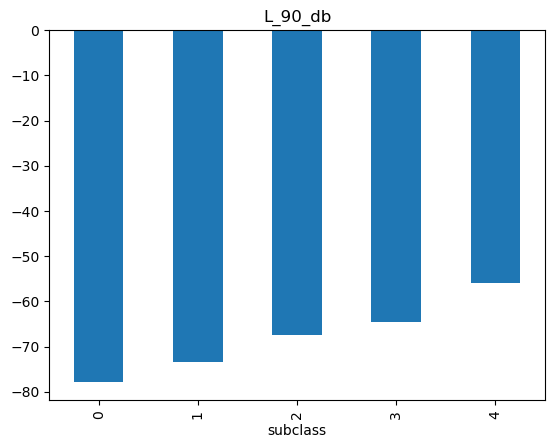

In [9]:
plot_by_col(df=df, col='L_90_db')

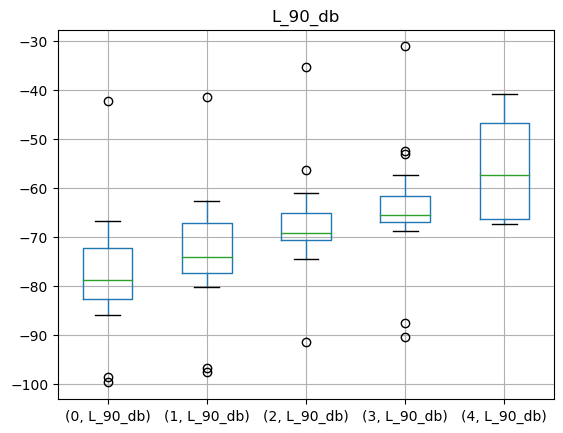

In [10]:
boxplot_by_col(df=df, col='L_90_db')

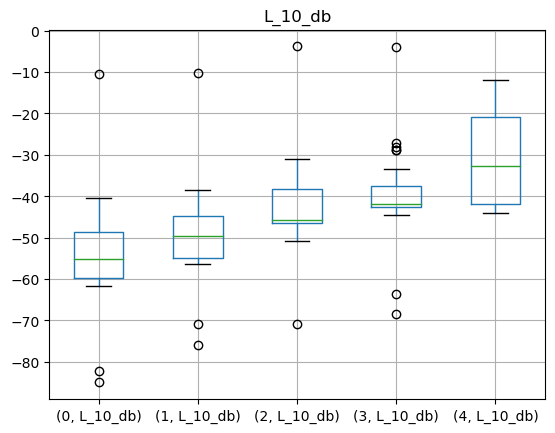

In [11]:
boxplot_by_col(df=df, col='L_10_db')

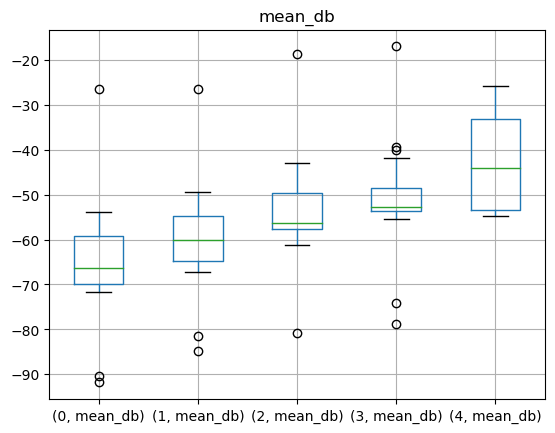

In [12]:
boxplot_by_col(df=df, col='mean_db')

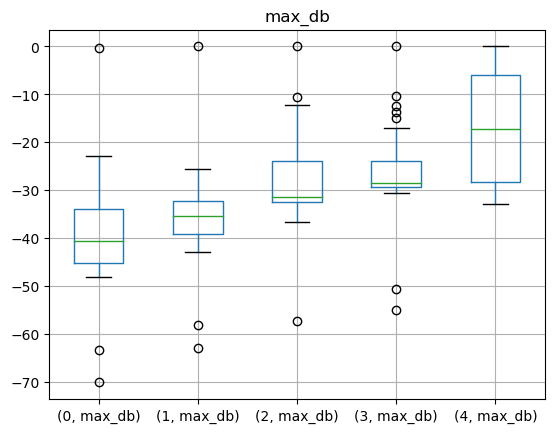

In [13]:
boxplot_by_col(df=df, col='max_db')

In [14]:
df.to_csv(os.path.join(features_path, 'sample_meta_w_L90.csv'), index=False)